### Draft File Disclaimer

As of this update, this file will contain unrun code that helps with version control. Once all queries are in, the file will be run to make sure all code work fine.

## Setup

In [62]:
# database
from neo4j import GraphDatabase
import psycopg2

# data processing
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'retina'  # Higher resolution figures

# utility
import random
import getpass
import geocoder
from statistics import mode
from datetime import datetime
from tqdm.notebook import tqdm

## Connections

***Important***: Before running anything below, please make sure you have a working Neo4j database and a PostgreSQL database running, which could include starting docker images or finding passwords for your `postgres` user. Also, please make sure to populate both databases using code and instructions in `data-loading.ipynb`.

**Note**: Change your PostgreSQL database information below as needed.

In [ ]:
# connect to postgres
pg_password = getpass.getpass("Enter Postgres Password: ")
pg = psycopg2.connect(
    dbname="accident_analysis",
    user="postgres",
    password=pg_password,
    host="localhost",
    port="5432"
)

In [ ]:
uri = "bolt://localhost:7666"
username = "neo4j"
password = "password"

def create_neo4j_session(uri, username, password):
    try:
        driver = GraphDatabase.driver(uri, auth=(username, password))
        session = driver.session()
        return session
    except Exception as e:
        print(f"Failed to create Neo4j session: {e}")
        return None

## Utility Functions

In [ ]:
def table_format(cur, rows):    
    # Format and print the table
    column_names = [desc[0] for desc in cur.description]  # Get the column names
    table_data = [column_names] + list(rows)  # Combine column names with row data

    # Calculate the maximum width for each column
    column_widths = [max(len(str(row[i])) for row in table_data) for i in range(len(column_names))]

    # Format and print the table headers
    header_format = "|".join(["{{:<{}}}".format(width) for width in column_widths])
    header = header_format.format(*column_names)
    print(header)
    print("-" * len(header))

    # Format and print the table rows
    row_format = "|".join(["{{:<{}}}".format(width) for width in column_widths])
    for row in table_data[1:]:
        formatted_row = []
        for i, value in enumerate(row):
            if isinstance(value, datetime):
                formatted_row.append(value.strftime("%Y-%m-%d %H:%M:%S"))  # Customize the datetime format as desired
            else:
                formatted_row.append(str(value))
        formatted_row = row_format.format(*formatted_row)
        print(formatted_row)


## Analysis Questions

### Part 1. Accident Information

#### Question: JG

What is the total number of accidents and the number of accidents with injuries or fatalities?

In [ ]:
cur = pg.cursor()
query = """
SELECT
    COUNT(*),
    SUM(CASE WHEN injured > 0 OR killed > 0 THEN 1 ELSE 0 END)
FROM accidents;
"""

cur.execute(query)
result = cur.fetchall()

time_qeury = "SELECT MIN(date_time), MAX(date_time) FROM accidents;"
cur.execute(time_qeury)
time_range = cur.fetchall()[0]
start = time_range[0].strftime("%Y.%m.%d")
end = time_range[1].strftime("%Y.%m.%d")
xlocs, xlabs = plt.xticks()

plt.bar(["total", "hurt"], result[0], color ='steelblue',
        width = 0.4)

for i, v in enumerate(result[0]):
    plt.text(i, v, str(v), ha='center', va='bottom', color='black')

injure_rate = result[0][1] / result[0][0]
plt.text(0.5, max(result[0]), f"Injury Rate: {int(injure_rate*100)}%",
        color='maroon', ha='center', va='bottom')

plt.xlabel("Accidents")
plt.ylabel("No. of Accidents")
plt.title(f"Accidents and Hurt Occurance in San Diego")
plt.show()
cur.close()

#### Question: JG

What is the percentage of accidents where hit-and-run was involved?

In [ ]:
cur = pg.cursor()
query = """
SELECT
    COUNT(*) AS total_accidents,
    COUNT(*) FILTER (WHERE hit_run_lvl = 'MISDEMEANOR' OR hit_run_lvl = 'FELONY')
FROM accidents;
"""

cur.execute(query)
result = cur.fetchall()

plt.bar(["total", "crime"], result[0], color ='steelblue',
        width = 0.4)

for i, v in enumerate(result[0]):
    plt.text(i, v, str(v), ha='center', va='bottom', color='black')

felony_rate = result[0][1] / result[0][0]
plt.text(0.5, max(result[0]), f"Crime Rate: {int(100*felony_rate)}%",
        color='maroon', ha='center', va='bottom')

plt.xlabel("Accidents")
plt.ylabel("No. of Accidents")
plt.title(f"Accidents and Crime Occurance in San Diego")
plt.show()

print(result)
cur.close()

#### Question: JG

What is the most common violation types in accidents?

In [ ]:
cur = pg.cursor()
query = """
SELECT
    violation_type,
    COUNT(*) AS total_accidents
FROM accidents
GROUP BY violation_type
ORDER BY total_accidents DESC;
"""

cur.execute(query)
result = cur.fetchall()

violation_types = [row[0] for row in result]
total_accidents = [row[1] for row in result]

normalized_accidents = np.log10(total_accidents)+1

fig, ax = plt.subplots(figsize=(10, 6))
bar_colors = ['steelblue' for _ in violation_types]
ax.barh(violation_types, normalized_accidents, color=bar_colors)

max_index = np.argmax(normalized_accidents)
ax.patches[max_index].set_facecolor('orange')

for i, v in enumerate(normalized_accidents):
    ax.text(v + 0.05, i, f"{total_accidents[i]}", color='black', va='center')

plt.xticks([])
plt.title("Total Accidents by Violation Type")
plt.xlabel("Total Accidents")
plt.ylabel("Violation Type")

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

print(result)
cur.close()

#### Question: YW

In what community(s) do accidents most densely occur in San Diego?

In [ ]:
session = create_neo4j_session(uri, username, password)

# add full graph to GDS
project_full_graph = """
CALL gds.graph.project(
    'fullGraph',
    ['Accident'],
    {CLOSE_TO: {orientation: 'UNDIRECTED', type:'WITHIN_RANGE'}}
)
"""

result = session.run(project_full_graph)
result.consume()
session.close()

In [ ]:
def get_community(locations, sample_prop=.05):
    result_locations = []
    for loc in locations:
        if not (random.randint(1, int(1/sample_prop)) - 1):  # randomly pick
            location = geocoder.osm(list(loc), method='reverse')
            if location.ok:
                address = location.raw['address']
                community = address.get('suburb') or address.get('neighbourhood') or address.get('city')
                if community:
                    result_locations.append(community)
    return mode(result_locations)

In [ ]:
def dense_accident_communities(num_communities, gds_name='fullGraph', sample_prop=0.02):
    session = create_neo4j_session(uri, username, password)

    # find largest component in GDS
    community_detection = f"""
    CALL gds.beta.leiden.stream('{gds_name}')
    YIELD nodeId, communityId
    WITH communityId, count(*) AS communitySize, collect(gds.util.asNode(nodeId)) AS communityNodes
    ORDER BY communitySize DESC
    LIMIT {num_communities}

    UNWIND communityNodes AS n
    RETURN n.pt AS loc, communityId AS cId, communitySize AS cSize
    """

    result = session.run(community_detection)

    community_results = [(
        record['loc'].latitude, 
        record['loc'].longitude, 
        record['cId'],
        record['cSize']
    ) for record in result]
    session.close()
    
    # post processing
    comm_df = pd.DataFrame(community_results, columns=['lat', 'lng', 'cId', 'num_accidents'])
    communities = comm_df.groupby(['cId', 'num_accidents']).apply(lambda df: get_community(
        df[['lat', 'lng']].to_records(index=False), sample_prop=sample_prop
    ))
    
    return (
        communities
        .reset_index()
        .drop(columns=['cId'])
        .sort_values(by='num_accidents', ascending=False)
        .rename(columns={0: 'community'})
        .to_dict('records')
    )

In [ ]:
dense_accident_communities(3, sample_prop=0.02)

#### Question: YW

In what community(s) do accidents involving more injures (>2) most densely occur in San Diego?

In [ ]:
def dense_more_injury_communities(num_communities, sample_prop=0.5):
    # find accident ids with more injuries
    cur = pg.cursor()
    query = """
    SELECT report_id
    FROM accidents
    WHERE injured > 2
    AND date_time >= '2022-01-01'
    """
    cur.execute(query)
    severe_ids = list(map(lambda tup: tup[0], cur.fetchall()))
    cur.close()
    
    # find severe accident and construct GDS graph
    session = create_neo4j_session(uri, username, password)

    severe_accidents_gds = f"""
    UNWIND {severe_ids} AS nId
    UNWIND {severe_ids} AS mId
    MATCH (n:Accident {{id: nId}})-[edges:WITHIN_RANGE]-(m:Accident {{id: mId}})
    WHERE id(n) > id(m)

    WITH DISTINCT edges AS r
    WITH startNode(r) AS startNode, endNode(r) AS endNode
    WITH gds.alpha.graph.project(
        'severeAccidents',
        startNode,
        endNode,
        {{}},
        {{}},
        {{undirectedRelationshipTypes: ['*']}}
    ) AS g
    RETURN g
    """
    
    result = session.run(severe_accidents_gds)
    session.close()
    
    # find communities
    communities = dense_accident_communities(num_communities, gds_name='severeAccidents', sample_prop=sample_prop)
    
    # drop gds graph
    try:
        session = create_neo4j_session(uri, username, password)
        drop_gds = "CALL gds.graph.drop('severeAccidents')"
        session.run(drop_gds)
    except:
        print('Dropping Graph Failed')
    finally:
        session.close()
    
    return communities

In [ ]:
dense_more_injury_communities(5, sample_prop=0.5)

#### Question: YW

For each month represented in the graph, where did accidents most frequently occur?

In [ ]:
def monthly_dense_communities(sample_prop=0.2):
    # find accident ids with more injuries
    cur = pg.cursor()
    query = """
    SELECT to_char(date_time, 'YYYY-MM') AS year_month, ARRAY_AGG(report_id)
    FROM accidents
    WHERE date_time >= '2022-01-01'
    GROUP BY year_month
    """
    cur.execute(query)
    monthly_accidents = list(map(lambda tup: (tup[0], list(tup[1])), cur.fetchall()))
    cur.close()
    
    # process each month
    monthly_results = []
    for month, node_ids in monthly_accidents:
        session = create_neo4j_session(uri, username, password)
        create_gds = f"""
        UNWIND {node_ids} AS nId
        UNWIND {node_ids} AS mId
        MATCH (n:Accident {{id: nId}})-[edges:WITHIN_RANGE]-(m:Accident {{id: mId}})
        WHERE id(n) > id(m)

        WITH DISTINCT edges AS r
        WITH startNode(r) AS startNode, endNode(r) AS endNode
        WITH gds.alpha.graph.project(
            'monthlyAccidents',
            startNode,
            endNode,
            {{}},
            {{}},
            {{undirectedRelationshipTypes: ['*']}}
        ) AS g
        RETURN g
        """
        result = session.run(create_gds)
        result.consume()

        # find communities
        community = dense_accident_communities(1, gds_name='monthlyAccidents', sample_prop=sample_prop)[0]
        community['month'] = month
        monthly_results.append(community)

        # drop graph view
        drop_gds = "CALL gds.graph.drop('monthlyAccidents')"
        result = session.run(drop_gds)
        result.consume()
        session.close()

    return monthly_results

In [ ]:
monthly_dense_communities(sample_prop=0.5)

#### Question: YW

For each 2-hour period in a day, where did accidents most frequently occur?

In [ ]:
def hourly_dense_communities(period=2, sample_prop=0.2):
    # find accident ids with more injuries
    cur = pg.cursor()
    query = f"""
    SELECT
        to_char(date_time, 'HH24') :: INTEGER / {period} AS hour,
        ARRAY_AGG(report_id)
    FROM accidents
    WHERE date_time >= '2022-01-01'
    GROUP BY hour
    ORDER BY hour ASC
    """
    cur.execute(query)
    hourly_accidents = list(map(lambda tup: (tup[0], list(tup[1])), cur.fetchall()))
    cur.close()
    
    # process each hour group
    hourly_results = []
    for hour_group, node_ids in hourly_accidents:
        session = create_neo4j_session(uri, username, password)
        create_gds = f"""
        UNWIND {node_ids} AS nId
        UNWIND {node_ids} AS mId
        MATCH (n:Accident {{id: nId}})-[edges:WITHIN_RANGE]-(m:Accident {{id: mId}})
        WHERE id(n) > id(m)

        WITH DISTINCT edges AS r
        WITH startNode(r) AS startNode, endNode(r) AS endNode
        WITH gds.alpha.graph.project(
            'hourlyAccidents',
            startNode,
            endNode,
            {{}},
            {{}},
            {{undirectedRelationshipTypes: ['*']}}
        ) AS g
        RETURN g
        """
        result = session.run(create_gds)
        result.consume()

        # find communities
        community = dense_accident_communities(1, gds_name='hourlyAccidents', sample_prop=sample_prop)[0]
        start_hour = hour_group * period
        end_hour = (start_hour + period) % 24
        community['hours'] = f'{start_hour}:00-{end_hour}:00'
        hourly_results.append(community)

        # drop graph view
        drop_gds = "CALL gds.graph.drop('hourlyAccidents')"
        result = session.run(drop_gds)
        result.consume()
        session.close()

    return hourly_results

In [ ]:
hourly_dense_communities(period=2, sample_prop=0.05)

### Part 2. Accident Vehicle Information

#### Question: JG

What are the top 10 most common vehicle makes involved in accidents?

In [ ]:
cur = pg.cursor()
query = """
SELECT
    veh_make,
    COUNT(*) AS total_accidents
FROM accident_info
WHERE veh_make <> ''
GROUP BY veh_make
ORDER BY total_accidents DESC
LIMIT 10
"""

cur.execute(query)
result = cur.fetchall()

car_names = [car[0] for car in result]
accident_counts = [car[1] for car in result]

fig, ax = plt.subplots(figsize=(10, 6))
bar_colors = ['steelblue' for _ in range(len(car_names))]
ax.barh(car_names, accident_counts, color=bar_colors)

max_index = accident_counts.index(max(accident_counts))
ax.patches[max_index].set_facecolor('orange')

for i, v in enumerate(accident_counts):
    ax.text(v + 500, i, str(v), ha='left', va='center', fontsize=10)

plt.title("Top 10 Cars with Highest Number of Accidents")
plt.xlabel("Accident Count")
plt.ylabel("Car Make")

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='x', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

print(result)
cur.close()

#### Question: JG

What are the top 10 vehicles that have highest (injury or kill) to total_accident rate?

In [ ]:
cur = pg.cursor()
query = """
SELECT 
    veh_make, SUM(injured + killed), COUNT(*)
FROM accidents
JOIN accident_info ON accidents.report_id = accident_info.report_id
GROUP BY veh_make
HAVING COUNT(*) > 15
ORDER BY CAST(SUM(injured + killed) AS float) / CAST(COUNT(*) AS float) DESC
LIMIT 10
"""

cur.execute(query)
result = cur.fetchall()

car_makes = [tup[0] for tup in result]
injury_kill = [tup[1] for tup in result]
num_accident = [tup[2] for tup in result]

fig, ax = plt.subplots(figsize=(10, 6))
bar_width = 0.3

index = np.arange(len(car_makes))
plt.bar(index, injury_kill, width=bar_width, color='steelblue', label='Injury or Kill Count')
plt.bar(index + bar_width, num_accident, width=bar_width, color='darkorange', label='Number of Accidents')

plt.xlabel('Car Makes')
plt.ylabel('Count')
plt.xticks(index + bar_width/2, car_makes, rotation=45, ha='right')

plt.legend()

# Add labels to the bars
for i, v in enumerate(injury_kill):
    plt.text(i, v, str(v), ha='center', va='bottom', fontweight='bold')

for i, v in enumerate(num_accident):
    plt.text(i + bar_width, v, str(v), ha='center', va='bottom', fontweight='bold')

# Add a title
plt.title('Car Makes with Highest Injury or Kill Counts and Number of Accidents')

# Show the plot
plt.tight_layout()
plt.show()

print(result)
cur.close()

#### Question: JG

Which road would a particular vehicle have the most (injury and kills) to accident rate?

*Author Note*: Small cars have higher probability to experience accidents with more injuries and kills on the same roads, than other types of vehicles such as bus or scooter.

In [ ]:
cur = pg.cursor()
query = """
SELECT 
    veh_make, road_name, SUM(injured + killed), COUNT(*)
FROM accidents
INNER JOIN accident_info 
    ON accidents.report_id = accident_info.report_id
INNER JOIN accidents_on_road
    ON accidents.report_id = accidents_on_road.report_id
INNER JOIN roads
    ON accidents_on_road.objectid = roads.objectid
GROUP BY veh_make, road_name
HAVING COUNT(*) > 10
    AND SUM(injured + killed) < (COUNT(*) * 5)
ORDER BY CAST(SUM(injured + killed) AS float) / CAST(COUNT(*) AS float) DESC
LIMIT 10
"""

cur.execute(query)
result = cur.fetchall()

car_road = [f"{tup[0]} @ {tup[1]}" for tup in result]
injury_kill = [tup[2] for tup in result]
num_accident = [tup[3] for tup in result]

fig, ax = plt.subplots(figsize=(10, 6))
bar_width = 0.3

index = np.arange(len(car_road))
plt.bar(index, injury_kill, width=bar_width, color='steelblue', label='Injury or Kill Count')
plt.bar(index + bar_width, num_accident, width=bar_width, color='darkorange', label='Number of Accidents')

plt.xlabel('Car Make @ Road')
plt.ylabel('Count')
plt.xticks(index + bar_width/2, car_road, rotation=45, ha='right')

plt.legend()

# Add labels to the bars
for i, v in enumerate(injury_kill):
    plt.text(i, v, str(v), ha='center', va='bottom', fontweight='bold')

for i, v in enumerate(num_accident):
    plt.text(i + bar_width, v, str(v), ha='center', va='bottom', fontweight='bold')

# Add a title
plt.title('Car Makes and Roads with Highest Injury or Kill Counts and Number of Accidents')

# Show the plot
plt.tight_layout()
plt.show()

print(result)
cur.close()

#### Question: YW

Do accidents involving different vehicle types (i.e. Bird Scooters, BMW, etc.) tend to happen in specific places or distributed randomly?

*Definition*: Since we define an `WITHIN_RANGE` edge only when two `Accident` nodes happen less than 500 meters between each other, we determine how many total accidents on average happen around an accident involving a specific type of vehicle.

In [ ]:
def vehicle_type_centrality(*vehicle_types):
    result = []
    for vehicle_type in vehicle_types:
        # find accidents with specific type
        cur = pg.cursor()
        query = f"""
        SELECT DISTINCT report_id
        FROM accident_info 
        WHERE veh_make = '{vehicle_type}'
        """
        cur.execute(query)
        veh_acc = list(map(lambda tup: tup[0], cur.fetchall()))
        cur.close()
        
        # find related accidents
        session = create_neo4j_session(uri, username, password)

        bird_graph = f"""
        UNWIND {veh_acc} AS aId
        MATCH (a:Accident {{id: aId}})-[r:WITHIN_RANGE]->(b)
        RETURN COUNT(b) AS num
        """

        graph_result = session.run(bird_graph)
        veh_result = [record['num'] for record in graph_result][0]
        session.close()
        
        result.append({
            'type': vehicle_type, 
            'total_accidents': len(veh_acc),
            'average_around': round(veh_result / len(veh_acc), 3) if len(veh_acc) > 0 else 0.0
        })
        
    return result

In [ ]:
vehicle_type_centrality('TOYOTA', 'HONDA', 'BIRD', 'HARLEY-DAVIDSON', 'LIME')

#### Question: HT

What are the top 2 ranking of total number of accidents for each vehicle make for each month in a year?

In [ ]:
cur = pg.cursor()
query = """
WITH ranked_accidents AS (
    SELECT ai.veh_make as veh_make, 
           EXTRACT(MONTH FROM a.date_time) AS accident_month,
           COUNT(*) AS total_accidents,
           RANK() OVER (PARTITION BY EXTRACT(MONTH FROM a.date_time) ORDER BY COUNT(*) DESC) AS rank
    FROM accident_info ai
    INNER JOIN accidents a ON ai.report_id = a.report_id
    GROUP BY ai.veh_make, accident_month
)
SELECT accident_month, veh_make, total_accidents
FROM ranked_accidents
WHERE rank <= 2;
"""
cur.execute(query)
rows = cur.fetchall()
table_format(cur, rows)
cur.close()

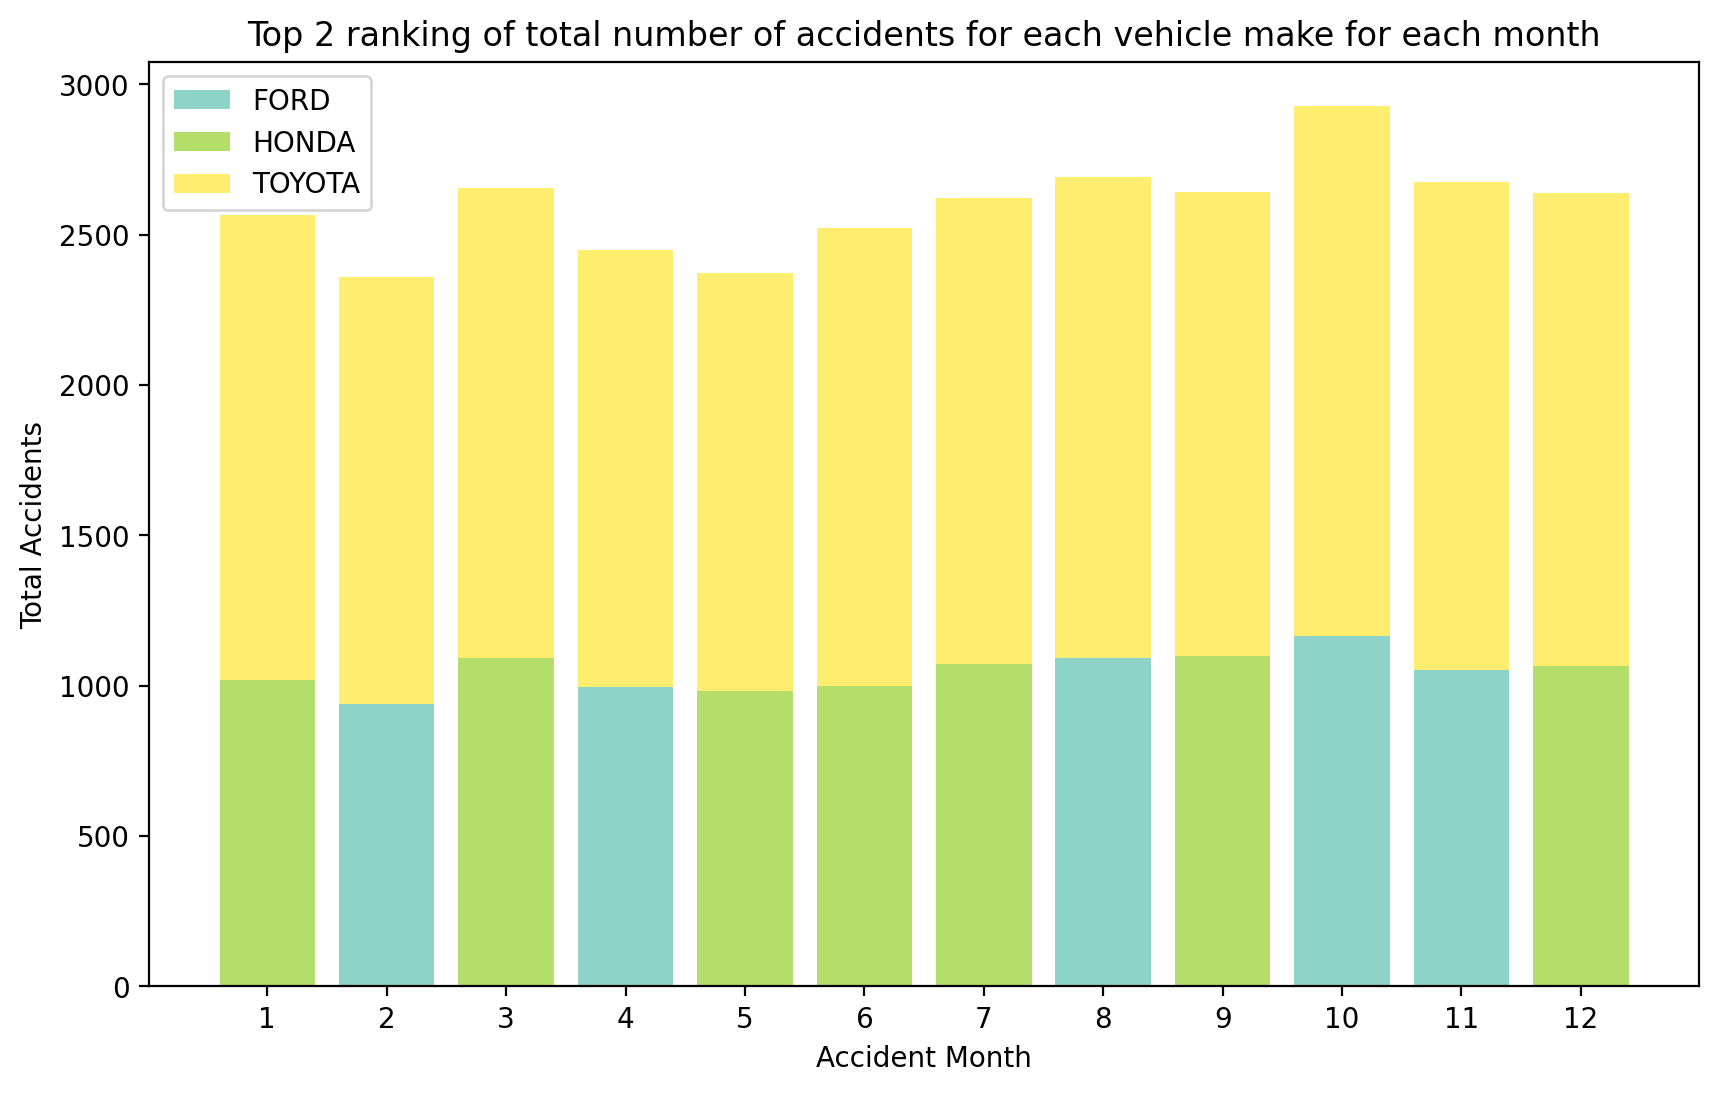

In [69]:
# group data by month and make
accident_month = [r[0] for r in rows]
veh_make = [r[1] for r in rows]
total_accidents = [r[2] for r in rows]

grouped_data = {}
for month, make, accidents in zip(accident_month, veh_make, total_accidents):
    key = (month, make)
    if key in grouped_data:
        grouped_data[key] += accidents
    else:
        grouped_data[key] = accidents

unique_months = sorted(set(accident_month))
unique_veh_make = sorted(set(veh_make))

# plot
plt.figure(figsize=(10, 6))
x_positions = np.arange(len(unique_months))
y_positions = np.zeros((len(unique_veh_make), len(unique_months)))
colors = plt.cm.get_cmap('Set3', len(unique_veh_make))

for i, make in enumerate(unique_veh_make):
    for j, month in enumerate(unique_months):
        key = (month, make)
        if key in grouped_data:
            y_positions[i, j] = grouped_data[key]

    plt.bar(x_positions, y_positions[i], bottom=np.sum(y_positions[:i], axis=0), color=colors(i))

plt.xticks(x_positions, unique_months)
plt.xlabel('Accident Month')
plt.ylabel('Total Accidents')
plt.title('Top 2 ranking of total number of accidents for each vehicle make for each month')

legend_labels = unique_veh_make
plt.legend(legend_labels)
plt.show()

In [ ]:
# # side-by-side barplot
# accident_month = np.array(rows)[:, 0]
# veh_make = np.array(rows)[:, 1]
# total_accidents = np.array(rows)[:, 2]

# # unique vehicle make, color
# unique_veh_make = list(set(veh_make))
# color_map = plt.cm.get_cmap('Set3')
# colors = color_map(np.linspace(0, 1, len(unique_veh_make)))

# # plot
# plt.figure(figsize=(10, 6))
# x_ticks = []
# x_positions = []
# legend_added = []

# offset = 0.4
# for i, month in enumerate(set(accident_month)):
#     month_indices = [j for j in range(len(accident_month)) if accident_month[j] == month]
#     x_positions.extend(month_indices)
#     x_ticks.append(np.mean(month_indices))
#     for j, make in enumerate(unique_veh_make):
#         make_indices = [k for k in month_indices if veh_make[k] == make]
#         make_accidents = [total_accidents[k] for k in make_indices]
#         plt.bar(np.array(make_indices) + i * offset, make_accidents, color=colors[j])

#         if make not in legend_added:
#             plt.plot([], [], color=colors[j], label=make)
#             legend_added.append(make)

# plt.xticks(x_ticks, sorted(set(accident_month)))
# plt.xlabel('Accident Month')
# plt.ylabel('Total Accidents')
# plt.title('Total Accidents by Month and Vehicle Make')
# plt.legend()
# plt.show()

### Part 3. Accident Road Information

#### Question: JG

What are the top 5 roads with the highest number of accidents?

In [ ]:
cur = pg.cursor()
query = """
SELECT
    r.road_name,
    COUNT(*) AS total_accidents
FROM accidents_on_road a
JOIN roads r ON a.objectid = r.objectid
GROUP BY r.road_name
ORDER BY total_accidents DESC
LIMIT 5;
"""

cur.execute(query)
result = cur.fetchall()

road_names = [road[0] for road in result]
accident_counts = [road[1] for road in result]

fig, ax = plt.subplots(figsize=(10, 6))
bar_colors = ['steelblue' for _ in range(len(road_names))]
ax.barh(road_names, accident_counts, color=bar_colors)

max_index = accident_counts.index(max(accident_counts))
ax.patches[max_index].set_facecolor('orange')

for i, v in enumerate(accident_counts):
    ax.text(v + 50, i, str(v), ha='left', va='center', fontsize=10)

plt.title("Top 5 Roads with Highest Number of Accidents")
plt.xlabel("Accident Count")
plt.ylabel("Road Name")

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='x', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()
print(result)
cur.close()

#### Question: JG

Which road has the most felony and injury?

In [ ]:
cur = pg.cursor()
query = """
SELECT
    r.road_name,
    SUM(a.killed) AS total_killed,
    SUM(a.injured) AS total_injuries,
    COUNT(*) AS felony_count
FROM
    accidents AS a
JOIN
    accidents_on_road AS ar ON a.report_id = ar.report_id
JOIN
    roads AS r ON ar.objectid = r.objectid
WHERE
    (a.hit_run_lvl = 'FELONY' OR a.hit_run_lvl = 'MISDEMEANOR')
GROUP BY
    r.road_name
HAVING 
    COUNT(*) > 300
ORDER BY
    -- total_killed DESC, total_injuries DESC 
    (CAST(SUM(a.killed) AS float) / CAST(COUNT(*) AS float)) DESC --, (SUM(a.injured)/COUNT(*)) DESC
LIMIT 10;
"""

cur.execute(query)
result = cur.fetchall()

roads = [tup[0] for tup in result]
kill_counts = [tup[1] * 5 for tup in result]
injury_counts = [tup[2] for tup in result]
accident_counts = [tup[3] for tup in result]

session = create_neo4j_session(uri, username, password)
accdident_total_2022 = []

for tup in result:
    road_name = tup[0]
    
    query = """
    MATCH (r:Road {name: $roadName})<-[:HAPPENS_ON]-(a:Accident)
    RETURN COUNT(a) AS accident_count
    """
    
    q_result = session.run(query, roadName=road_name)
    
    for r in q_result:
        accdident_total_2022.append(r["accident_count"])

session.close()
accdident_total_2022

accident_counts_2022 = accdident_total_2022

fig, ax = plt.subplots(figsize=(10, 6))
bar_width = 0.3

index = np.arange(len(roads))
plt.bar(index, kill_counts, width=bar_width, color='steelblue', label='Kills Count')
plt.bar(index + bar_width, injury_counts, width=bar_width, color='darkorange', label='Total Injuries')
plt.bar(index + 2 * bar_width, accident_counts, width=bar_width, color='green', label='Total Accidents')
plt.bar(index + 2 * bar_width, accident_counts_2022, width=bar_width, color='skyblue', label='Total Accidents (2022 onwards)')

plt.xlabel('Roads')
plt.ylabel('Count')
plt.xticks(index + bar_width, roads, rotation=45, ha='right')

plt.legend()

for i, v in enumerate(kill_counts):
    plt.text(i, v, str(v // 5), ha='center', va='bottom', fontweight='bold')

for i, v in enumerate(injury_counts):
    plt.text(i + bar_width, v, str(v), ha='center', va='bottom', fontweight='bold')

for i, v in enumerate(accident_counts):
    plt.text(i + 2 * bar_width, v, str(v), ha='center', va='bottom', fontweight='bold')

for i, v in enumerate(accident_counts_2022):
    plt.text(i + 2 * bar_width, v, str(v), ha='center', va='bottom', fontweight='bold')

plt.title('Roads with Highest Kill Counts to Total Accidents ratio')

plt.tight_layout()
plt.show()

#### Question: YW

What road features are most accidents associated with?

In [ ]:
# find distributions
cur = pg.cursor()
query = """
SELECT r.speed, COUNT(acc)
FROM accidents AS acc
LEFT JOIN accidents_on_road AS aor
ON acc.report_id = aor.report_id
LEFT JOIN roads AS r
ON aor.objectid = r.objectid
WHERE r.speed IS NOT NULL
GROUP BY r.speed
ORDER BY r.speed ASC
"""
cur.execute(query)
accident_speeds = cur.fetchall()
cur.close()

cur = pg.cursor()
query = """
SELECT r.speed, COUNT(*)
FROM roads AS r
WHERE r.speed IS NOT NULL
GROUP BY r.speed
ORDER BY r.speed ASC
"""
cur.execute(query)
all_speeds = cur.fetchall()
cur.close()

# normalize data 
speed_distr = (
    pd.DataFrame(all_speeds, columns=['speed', 'num_all'])
    .merge(pd.DataFrame(accident_speeds), how='outer', left_on='speed', right_on=0)
    .fillna(0)
    .drop(columns=[0])
    .rename(columns={1: 'num_accidents'})
    .sort_values(by='speed')
    .reset_index(drop=True)
)
speed_distr['num_accidents'] = (
    speed_distr['num_accidents'].astype(int) / 
    speed_distr['num_accidents'].sum()
)
speed_distr['num_all'] = speed_distr['num_all'] / speed_distr['num_all'].sum()

# plot
title = speed_distr.set_index('speed').plot(
    kind='bar', 
    rot=0,
    ylabel='Percentage',
    title='Comparison of Speed Limit Distributions',
    figsize=(10, 4)
)

#### Question: YW

Are one-way roads more likely to have accidents?

In [ ]:
# find distributions
cur = pg.cursor()
query = """
SELECT 
    CASE WHEN r.oneway = 'B' THEN 'Two-Way' ELSE 'One-Way' END AS info,
    COUNT(acc)
FROM accidents AS acc
LEFT JOIN accidents_on_road AS aor
ON acc.report_id = aor.report_id
LEFT JOIN roads AS r
ON aor.objectid = r.objectid
WHERE r.oneway <> ''
GROUP BY info
"""
cur.execute(query)
accident_oneways = cur.fetchall()
cur.close()

cur = pg.cursor()
query = """
SELECT 
    CASE WHEN r.oneway = 'B' THEN 'Two-Way' ELSE 'One-Way' END AS info, 
    COUNT(*)
FROM roads AS r
WHERE r.oneway IS NOT NULL
GROUP BY info
"""
cur.execute(query)
all_oneways = cur.fetchall()
cur.close()

# normalize data 
oneway_distr = (
    pd.DataFrame(all_oneways, columns=['oneway', 'num_all'])
    .merge(pd.DataFrame(accident_oneways), how='outer', left_on='oneway', right_on=0)
    .fillna(0)
    .drop(columns=[0])
    .rename(columns={1: 'num_accidents'})
    .sort_values(by='oneway')
    .reset_index(drop=True)
)
oneway_distr['num_accidents'] = (
    oneway_distr['num_accidents'].astype(int) / 
    oneway_distr['num_accidents'].sum()
)
oneway_distr['num_all'] = oneway_distr['num_all'] / oneway_distr['num_all'].sum()

# plot
title = oneway_distr.set_index('oneway').plot(
    kind='bar', 
    rot=0,
    ylabel='Percentage',
    title='Comparison of Street Direction(s) Distributions'
)

### Part 4. Accident Information in Relation to Get-It-Done Reports

#### Question: HT

What are the top 3 ranking of total number of reports for each service for each month?

In [ ]:
cur = pg.cursor()
query = """
WITH ranked_accidents AS (
    SELECT service_name, 
           EXTRACT(MONTH FROM date_requested) AS request_month,
           COUNT(*) AS total_reports,
           RANK() OVER (PARTITION BY EXTRACT(MONTH FROM date_requested) ORDER BY COUNT(*) DESC) AS rank
    FROM reports
    GROUP BY service_name, request_month
)
SELECT request_month, service_name, total_reports
FROM ranked_accidents
WHERE rank <= 3;
"""
cur.execute(query)
rows = cur.fetchall()
table_format(cur, rows)
cur.close()

In [ ]:
request_month = np.array(rows)[:, 0]
service_name = np.array(rows)[:, 1]
total_reports = np.array(rows)[:, 2]

# unique service names, assign colors
unique_service_name = list(set(service_name))
color_map = plt.cm.get_cmap('Set3')
colors = color_map(np.linspace(0, 1, len(unique_service_name)))

# plot
plt.figure(figsize=(10, 6))
x_ticks = []
x_positions = []
legend_added = []
offset = 0.6

for i, month in enumerate(set(request_month)):
    month_indices = [j for j in range(len(request_month)) if request_month[j] == month]
    x_positions.extend(month_indices)
    x_ticks.append(np.mean(month_indices))
    for j, service in enumerate(unique_service_name):
        service_indices = [k for k in month_indices if service_name[k] == service]
        service_reports = [total_reports[k] for k in service_indices]
        plt.bar(np.array(service_indices) + i * offset, service_reports, color=colors[j])

        if service not in legend_added:
            plt.plot([], [], color=colors[j], label=service)
            legend_added.append(service)

plt.xticks(x_ticks, sorted(set(request_month)))
plt.xlabel('Request Month')
plt.ylabel('Total Reports')
plt.title('Top 3 ranking of total number of reports for each service for each month')
plt.legend()
plt.show()

#### Question: YW

Do accidents tend to happen on roads that require more fixes?

In [ ]:
session = create_neo4j_session(uri, username, password)

report_accident = """
MATCH (a:Accident)-[:HAPPENS_ON]->(road:Road)
WITH road, count(a) AS numAccidents
MATCH (re:Report)-[:REPORTED_ON]->(road)
RETURN road, numAccidents, COUNT(*) AS numReports
"""
result = session.run(report_accident)
report_accident_count = [
    (record['numAccidents'], record['numReports'])
    for record in result
]

session.close()

In [ ]:
pd.DataFrame(report_accident_count, columns=['numAccidents', 'numReports']).plot(
    kind='scatter', 
    x='numAccidents', 
    y='numReports', 
    title='Correlation between Numbers of Accidents and Reports'
)

#### Question: YW

For roads that have high accident numbers, what kinds of reports are most likely observed?

In [ ]:
def frequent_report_types(top_n=10):
    # find top accident roads
    session = create_neo4j_session(uri, username, password)

    top_roads = f"""
    MATCH (a:Accident)-[:HAPPENS_ON]->(road:Road)
    WITH road, COUNT(a) AS numAccident
    MATCH (re:Report)-[:REPORTED_ON]->(road)
    WITH numAccident, COLLECT(re.id) AS reports
    ORDER BY numAccident DESC
    LIMIT {top_n}
    UNWIND reports AS one_report
    RETURN one_report
    """

    graph_result = session.run(top_roads)
    report_result = tuple(record['one_report'] for record in graph_result)
    session.close()
    
    # find report types
    cur = pg.cursor()
    query = f"""
    SELECT service_name, COUNT(*) AS num_services
    FROM reports 
    WHERE service_request_id IN {report_result}
    GROUP BY service_name
    ORDER BY num_services DESC
    """
    cur.execute(query)
    report_types = cur.fetchall()
    cur.close()
    
    return report_types

In [ ]:
frequent_types = frequent_report_types(top_n=10)
frequent_types

In [ ]:
# compare to original distribution
cur = pg.cursor()
query = """
SELECT service_name, COUNT(*) AS num_services
FROM reports 
GROUP BY service_name
ORDER BY num_services DESC
"""
cur.execute(query)
all_report_types = cur.fetchall()
cur.close()

# normalize data 
report_distr = (
    pd.DataFrame(all_report_types, columns=['service_type', 'total_services'])
    .merge(pd.DataFrame(frequent_types), how='left', left_on='service_type', right_on=0)
    .fillna(0)
    .drop(columns=[0])
    .rename(columns={1: 'accident_services'})
    .sort_values(by='accident_services', ascending=False)
    .reset_index(drop=True)
)
report_distr['accident_services'] = (
    report_distr['accident_services'].astype(int) / 
    report_distr['accident_services'].sum()
)
report_distr['total_services'] = report_distr['total_services'] / report_distr['total_services'].sum()

# plot
report_distr[report_distr['accident_services'] > 0.01].set_index('service_type').plot(
    kind='bar', 
    rot=45,
    ylabel='Percentage',
    title='Comparison of Report Service Type Distributions',
    figsize=(10, 4)
)

x_ticks = plt.xticks(ha='right')